In [1]:
import pandas as pd
import numpy as np

In [2]:
import yfinance as yf

In [ ]:
#pip install xgboost

In [3]:
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import matplotlib.pyplot as plt 

plt.style.use('dark_background')

In [4]:
import datetime as dt

In [ ]:
macro = pd.read_csv('/Users/atlantropa/Desktop/USC/Blockchain Club/Liquidity/Fed/macro_L.csv')

In [ ]:
SPY_LM1 = pd.read_csv('/Users/atlantropa/Desktop/USC/Blockchain Club/Liquidity/Fed/SPY_model_2021.csv')


In [ ]:
BTC_LM1 = pd.read_csv('/Users/atlantropa/Desktop/USC/Blockchain Club/Liquidity/Fed/BTC_model_2021.csv')


In [5]:
BTC_LEM2 = pd.read_csv('/Users/atlantropa/Desktop/USC/Blockchain Club/Liquidity/Fed/BTC_LEM2.csv')

In [6]:
BTC_LEM2

,Date,Open,High,Low,Close,Volume,Assets ($ Billion),TGA ($ Billion),RRP ($ Billion),Net Liquidity,...,USDT_30d ($ Million),USDT_90d ($ Million),USDC_1d ($ Million),USDC_7d ($ Million),USDC_30d ($ Million),USDC_90d ($ Million),Total Supply ($ Billion),Macro&Crypto Liquidity,PERP_OI_btc,PERP_FR_btc
0,2020-07-23,9527.141602,9610.247070,9483.003906,9581.072266,18146399002,6964.755,1804.944,0.000,5159.811,...,9187.991663,6361.032509,1112.861820,1101.684172,926.919889,734.284096,11.296681,5171.107681,20.90,0.00005
1,2020-07-24,9585.514648,9623.336914,9481.454102,9536.892578,16552768325,6964.755,1804.944,0.000,5159.811,...,9187.991663,6361.032509,1114.014303,1098.448596,926.919889,750.405209,11.282897,5171.093897,20.30,0.00002
2,2020-07-25,9539.485352,9704.556641,9530.211914,9677.113281,16610070933,6964.755,1804.944,0.000,5159.811,...,9187.991663,6361.032509,1105.896543,1102.128113,926.919889,751.318500,11.280737,5171.091737,21.20,0.00008
3,2020-07-26,9680.234375,10023.807617,9652.847656,9905.166992,20507998997,6964.755,1804.944,0.000,5159.811,...,9187.991663,6361.032509,1104.434260,1119.952382,926.919889,750.019696,11.307171,5171.118171,20.30,0.00026
4,2020-07-27,9905.217773,11298.221680,9903.969727,10990.873047,35359749590,6964.755,1804.944,0.000,5159.811,...,9187.991663,6361.032509,1132.450810,1118.855433,926.919889,745.794524,11.339053,5171.150053,20.70,0.00070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,11886957804,8564.411,459.780,2216.348,5888.283,...,65362.681003,67956.204625,44272.157228,44953.338668,43945.914716,49253.718780,128.009936,6016.292936,57.40,0.00003
887,2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,15748580239,8564.411,459.780,2221.259,5883.372,...,65362.681003,67956.206763,44401.878442,44553.485703,44145.819167,49049.231260,127.980687,6011.352687,59.05,0.00004
888,2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,17005713920,8551.169,427.926,2293.003,5830.240,...,65362.681003,67956.206763,44472.229084,44391.012623,44173.615773,48718.474573,127.678307,5957.918307,60.06,0.00010
889,2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,14472237479,8551.169,427.926,2308.319,5814.924,...,65362.681003,67956.206753,44277.626154,44278.574627,43741.798309,47763.014432,127.748428,5942.672428,61.02,0.00004


In [7]:
BTC_LEM2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           891 non-null    object 
 1   Open                           891 non-null    float64
 2   High                           891 non-null    float64
 3   Low                            891 non-null    float64
 4   Close                          891 non-null    float64
 5   Volume                         891 non-null    int64  
 6   Assets ($ Billion)             891 non-null    float64
 7   TGA ($ Billion)                891 non-null    float64
 8   RRP ($ Billion)                891 non-null    float64
 9   Net Liquidity                  891 non-null    float64
 10  Net Liquidity (Including TGA)  891 non-null    float64
 11  BUSD Supply ($ Million)        891 non-null    float64
 12  USDT Supply ($ Million)        891 non-null    flo

### Feature Engineering

In [8]:
#Conver to datetime
BTC_LEM2['Date'] = pd.to_datetime(BTC_LEM2['Date'])

#put everything into each category
BTC_LEM2['Year'] = BTC_LEM2['Date'].dt.year
BTC_LEM2['Month'] = BTC_LEM2['Date'].dt.month
BTC_LEM2['Day'] = BTC_LEM2['Date'].dt.day

In [9]:
BTC_LEM2.iloc[:, [1,2,3] + list(range(5, BTC_LEM2.shape[1]))]

,Open,High,Low,Volume,Assets ($ Billion),TGA ($ Billion),RRP ($ Billion),Net Liquidity,Net Liquidity (Including TGA),BUSD Supply ($ Million),...,USDC_7d ($ Million),USDC_30d ($ Million),USDC_90d ($ Million),Total Supply ($ Billion),Macro&Crypto Liquidity,PERP_OI_btc,PERP_FR_btc,Year,Month,Day
0,9527.141602,9610.247070,9483.003906,18146399002,6964.755,1804.944,0.000,5159.811,6964.755,184.444948,...,1101.684172,926.919889,734.284096,11.296681,5171.107681,20.90,0.00005,2020,7,23
1,9585.514648,9623.336914,9481.454102,16552768325,6964.755,1804.944,0.000,5159.811,6964.755,178.778536,...,1098.448596,926.919889,750.405209,11.282897,5171.093897,20.30,0.00002,2020,7,24
2,9539.485352,9704.556641,9530.211914,16610070933,6964.755,1804.944,0.000,5159.811,6964.755,178.080604,...,1102.128113,926.919889,751.318500,11.280737,5171.091737,21.20,0.00008,2020,7,25
3,9680.234375,10023.807617,9652.847656,20507998997,6964.755,1804.944,0.000,5159.811,6964.755,176.498650,...,1119.952382,926.919889,750.019696,11.307171,5171.118171,20.30,0.00026,2020,7,26
4,9905.217773,11298.221680,9903.969727,35359749590,6964.755,1804.944,0.000,5159.811,6964.755,171.996130,...,1118.855433,926.919889,745.794524,11.339053,5171.150053,20.70,0.00070,2020,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,16842.250000,16920.123047,16812.369141,11886957804,8564.411,459.780,2216.348,5888.283,6348.063,17360.410170,...,44953.338668,43945.914716,49253.718780,128.009936,6016.292936,57.40,0.00003,2022,12,26
887,16919.291016,16959.845703,16642.072266,15748580239,8564.411,459.780,2221.259,5883.372,6343.152,17260.811024,...,44553.485703,44145.819167,49049.231260,127.980687,6011.352687,59.05,0.00004,2022,12,27
888,16716.400391,16768.169922,16497.556641,17005713920,8551.169,427.926,2293.003,5830.240,6258.166,17153.033528,...,44391.012623,44173.615773,48718.474573,127.678307,5957.918307,60.06,0.00010,2022,12,28
889,16552.322266,16651.755859,16508.683594,14472237479,8551.169,427.926,2308.319,5814.924,6242.850,16976.192601,...,44278.574627,43741.798309,47763.014432,127.748428,5942.672428,61.02,0.00004,2022,12,29


### Lagging X & y

In [10]:
# Selecting Features 
X = BTC_LEM2.iloc[:, [1,2,3] + list(range(5, BTC_LEM2.shape[1]))]
#X = BTC_LEM2.iloc[:, list(range(5, BTC_LEM2.shape[1]))]
column_names = X.columns

In [11]:
# Creating time lags in X features
X_1d = X.drop(X.index[0])
print(X_1d.shape)

X_7d = X.drop(X.index[0:7])
print(X_7d.shape)

X_14d = X.drop(X.index[0:14])
print(X_14d.shape)

(890, 36)
(884, 36)
(877, 36)


In [12]:
# Match the time lag of X with y
y_1d = BTC_LEM2['Close'].shift(-1).dropna(inplace=False)
print(y_1d.shape)

y_7d = BTC_LEM2['Close'].shift(-7).dropna(inplace=False)
print(y_7d.shape)

y_14d = BTC_LEM2['Close'].shift(-14).dropna(inplace=False)
print(y_14d.shape)

(890,)
(884,)
(877,)


### Scaling X

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
#Scaling my X features
def scale_my_X(df):
    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler to the features
    scaler.fit(df)

    # Scale the features
    return scaler.transform(df)


In [15]:
#After it scaled, gotta attach them with column names 
Scaled_X_1d = scale_my_X(X_1d)
Scaled_X_1d = pd.DataFrame(Scaled_X_1d, columns=column_names)

Scaled_X_7d = scale_my_X(X_7d)
Scaled_X_7d = pd.DataFrame(Scaled_X_7d, columns=column_names)

Scaled_X_14d = scale_my_X(X_14d)
Scaled_X_14d = pd.DataFrame(Scaled_X_14d, columns=column_names)

## Splitting Data

In [16]:
# Setting up Params

# The random state is a random seed that is used to initialize the model 
#    and ensure reproducibility of results
seed = 42

test_size = 0.2

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Scaled_X_14d, y_14d, test_size=test_size, random_state=seed, shuffle=False)


# XG Boost

### XGBoost Fine-tune Hyperparameter

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 300]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [17]:
# Initialize variables to store scores
scores = []
mse = []
mae = []

# Split the data into n_splits chunks
n_splits = 10
chunks = np.array_split(range(len(Scaled_X_7d)), n_splits)
for i in range(n_splits):
    # Get the test data
    test_index = chunks[i]
    X_test, y_test = Scaled_X_7d.iloc[test_index], y_7d.iloc[test_index]
    # Get the train data
    train_index = list(set(range(len(Scaled_X_7d))).difference(test_index))
    X_train, y_train = Scaled_X_7d.iloc[train_index], y_7d.iloc[train_index]
    # Initialize the model
    model = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 50)
    # fit the model 
    model.fit(X_train, y_train)
    # Calculate accuracy score
    accuracy_score = model.score(X_test, y_test)
    scores.append(accuracy_score)
    # Make predictions
    y_pred = model.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))

In [19]:
print("Mean accuracy score: ", scores[-1])
print("Mean MSE: ", np.mean(mse))
print("Mean MAE: ", np.mean(mae))

Mean accuracy score:  0.9153725972694985
Mean MSE:  1633900.37672351
Mean MAE:  934.9641936850621


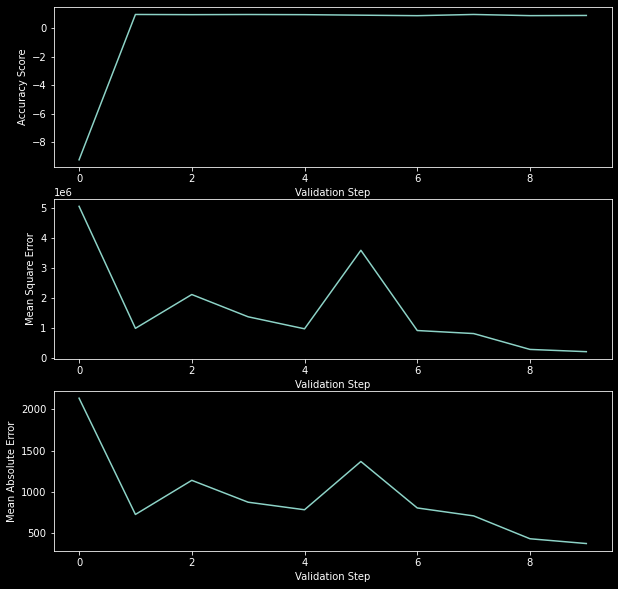

In [20]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=3)

ax[0].plot(scores)
ax[0].set_xlabel('Validation Step')
ax[0].set_ylabel('Accuracy Score')

ax[1].plot(mse)
ax[1].set_xlabel('Validation Step')
ax[1].set_ylabel('Mean Square Error')

ax[2].plot(mae)
ax[2].set_xlabel('Validation Step')
ax[2].set_ylabel('Mean Absolute Error')


plt.show()

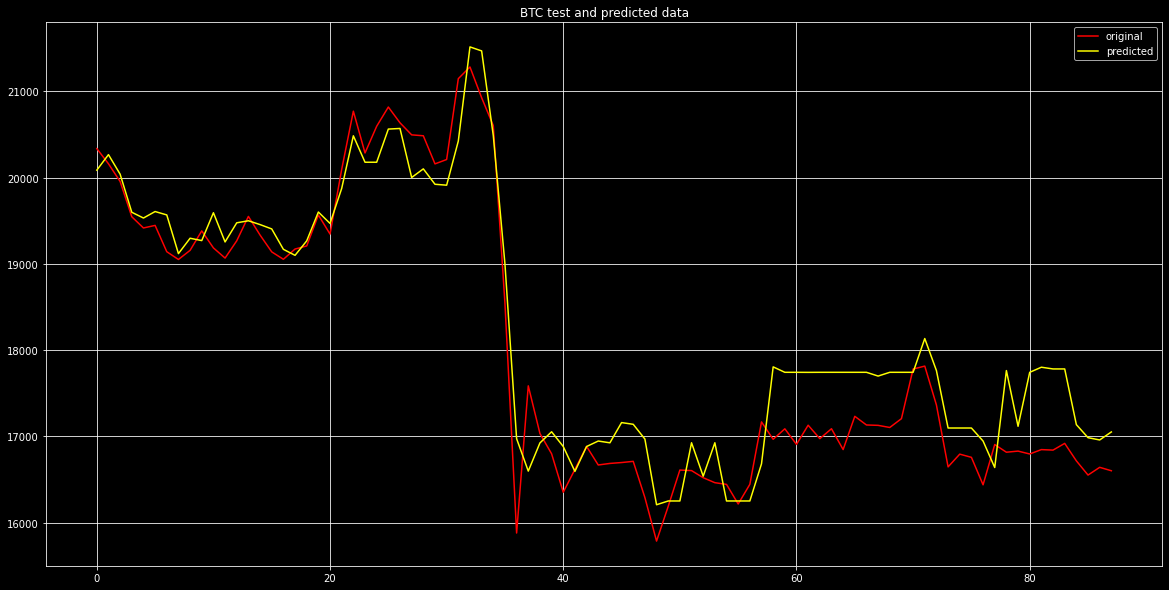

In [21]:
# Visualization 
x_ax = range(len(y_test))
plt.subplots(figsize=(20, 10))
plt.plot(x_ax, y_test, label="original", color = 'red')
plt.plot(x_ax, y_pred, label="predicted", color = 'yellow')
plt.title("BTC test and predicted data")
plt.grid()
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

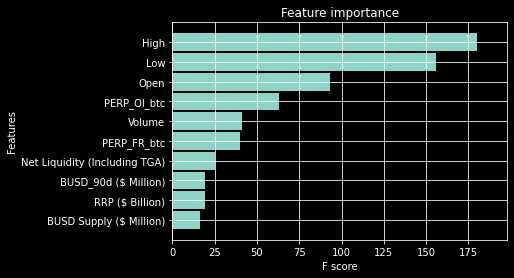

In [22]:
importances = model.get_booster().get_fscore()
importance_df = pd.DataFrame({
    'feature': list(importances.keys()),
    'importance': list(importances.values())
}).sort_values('importance', ascending=False)

top_10_features = importance_df.head(20)
xgb.plot_importance(model, height = 0.9, importance_type = 'weight', show_values = False, grid=True, max_num_features=10)


## XGBoost After Dimension Reduction

In [23]:
Fil_Scaled_X_14d = Scaled_X_14d[['Open', 'High', 'Low', 'Volume', 'PERP_OI_btc', 'PERP_FR_btc', 'Net Liquidity (Including TGA)']]

# Setting up Params

# The random state is a random seed that is used to initialize the model 
#    and ensure reproducibility of results
seed = 42

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(Fil_Scaled_X_14d, y_14d, test_size=test_size, random_state=seed, shuffle=False)


In [24]:
# Initialize variables to store scores
scores = []
mse = []
mae = []

# Split the data into n_splits chunks
n_splits = 10
chunks = np.array_split(range(len(Fil_Scaled_X_14d)), n_splits)
for i in range(n_splits):
    # Get the test data
    test_index = chunks[i]
    X_test, y_test = Fil_Scaled_X_14d.iloc[test_index], y_14d.iloc[test_index]
    # Get the train data
    train_index = list(set(range(len(Fil_Scaled_X_14d))).difference(test_index))
    X_train, y_train = Fil_Scaled_X_14d.iloc[train_index], y_14d.iloc[train_index]
    # Initialize the model
    model = XGBRegressor(learning_rate = 0.1, max_depth = 9, n_estimators = 50)
    # fit the model 
    model.fit(X_train, y_train)
    # Calculate accuracy score
    accuracy_score = model.score(X_test, y_test)
    scores.append(accuracy_score)
    # Make predictions
    y_pred = model.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))

In [25]:
print("Mean accuracy score: ", scores[-1])
print("Mean MSE: ", np.mean(mse))
print("Mean MAE: ", np.mean(mae))

Mean accuracy score:  0.9556811086409931
Mean MSE:  1500603.5832336713
Mean MAE:  881.480425853191


In [26]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 300]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50}


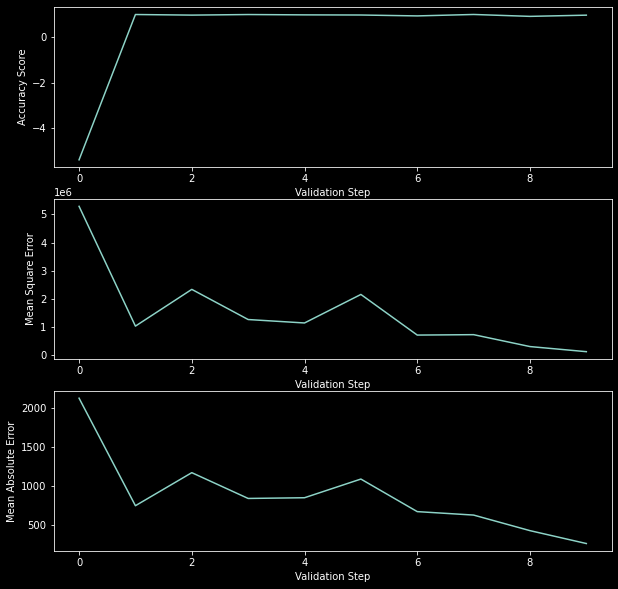

In [27]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=3)

ax[0].plot(scores)
ax[0].set_xlabel('Validation Step')
ax[0].set_ylabel('Accuracy Score')

ax[1].plot(mse)
ax[1].set_xlabel('Validation Step')
ax[1].set_ylabel('Mean Square Error')

ax[2].plot(mae)
ax[2].set_xlabel('Validation Step')
ax[2].set_ylabel('Mean Absolute Error')


plt.show()

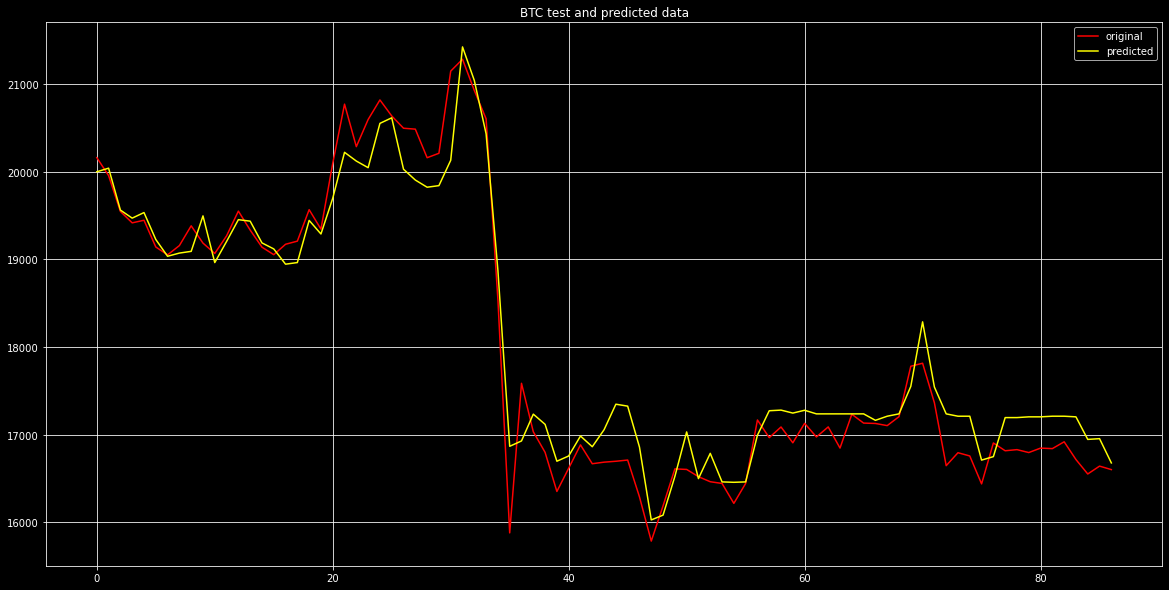

In [28]:
# Visualization 
x_ax = range(len(y_test))
plt.subplots(figsize=(20, 10))
plt.plot(x_ax, y_test, label="original", color = 'red')
plt.plot(x_ax, y_pred, label="predicted", color = 'yellow')
plt.title("BTC test and predicted data")
plt.grid()
plt.legend()
plt.show()

# Random Forest Model

In [29]:
from sklearn.ensemble import RandomForestRegressor

### Random Forest Hyperparam Fine-tuning 

In [32]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# Initialize the model
rf = RandomForestRegressor()

# Perform grid search
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 50}


In [33]:
# Initialize variables to store scores
scores = []
mse = []
mae = []
mape = []

# Split the data into n_splits chunks
n_splits = 10
chunks = np.array_split(range(len(Fil_Scaled_X_14d)), n_splits)
for i in range(n_splits):
    # Get the test data
    test_index = chunks[i]
    X_test, y_test = Fil_Scaled_X_14d.iloc[test_index], y_14d.iloc[test_index]
    # Get the train data
    train_index = list(set(range(len(Fil_Scaled_X_14d))).difference(test_index))
    X_train, y_train = Fil_Scaled_X_14d.iloc[train_index], y_14d.iloc[train_index]
    # Initialize the model
    model = RandomForestRegressor(max_depth = 7, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 50)
    # fit the model 
    model.fit(X_train, y_train)
    # Calculate accuracy score
    accuracy_score = model.score(X_test, y_test)
    scores.append(accuracy_score)
    # Make predictions
    y_pred = model.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))
    mape.append((np.abs((y_test - y_pred) / y_test)) * 100)

In [34]:
print("Mean accuracy score: ", scores[-1])
print("Mean MSE: ", np.mean(mse))
print("Mean MAE: ", np.mean(mae))
#print("Mean MAPE: ", np.mean(mape))

Mean accuracy score:  0.9465243706210974
Mean MSE:  1684058.1296659987
Mean MAE:  918.9675723190148


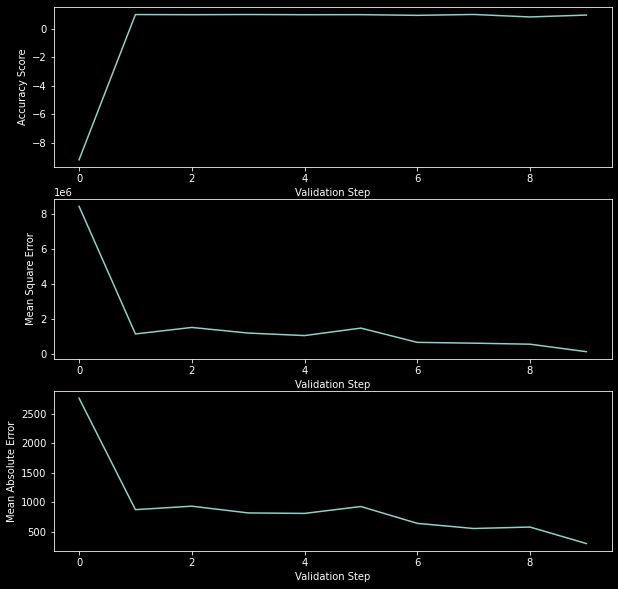

In [35]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=3)

ax[0].plot(scores)
ax[0].set_xlabel('Validation Step')
ax[0].set_ylabel('Accuracy Score')

ax[1].plot(mse)
ax[1].set_xlabel('Validation Step')
ax[1].set_ylabel('Mean Square Error')

ax[2].plot(mae)
ax[2].set_xlabel('Validation Step')
ax[2].set_ylabel('Mean Absolute Error')


plt.show()

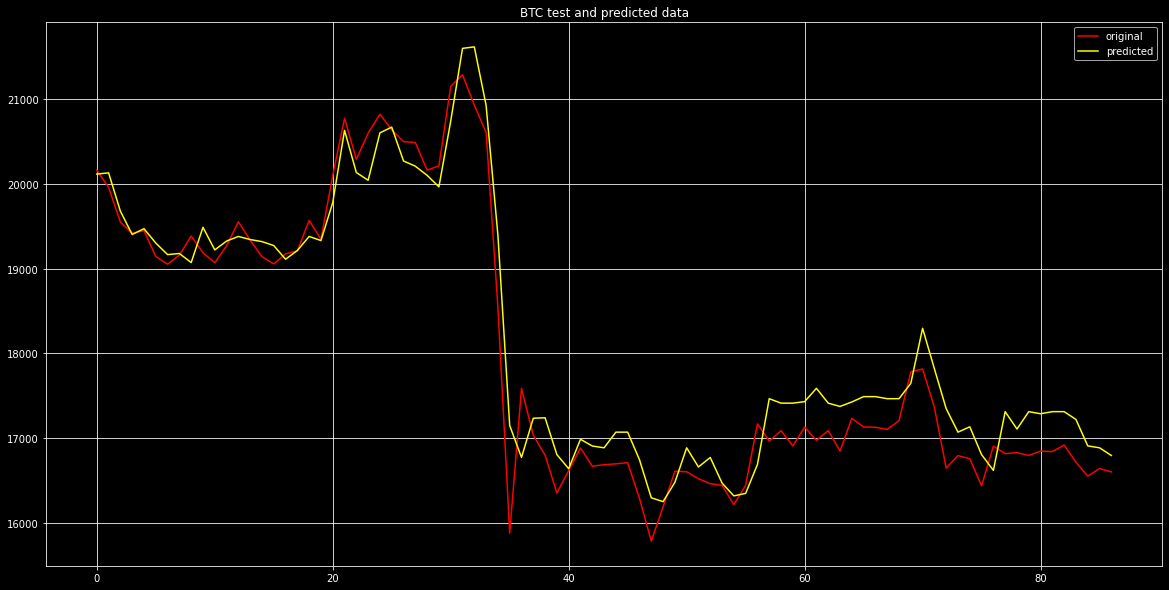

In [36]:
# Visualization 
y_pred = model.predict(X_test)

x_ax = range(len(y_test))
plt.subplots(figsize=(20, 10))
plt.plot(x_ax, y_test, label="original", color = 'red')
plt.plot(x_ax, y_pred, label="predicted", color = 'yellow')
plt.title("BTC test and predicted data")
plt.grid()
plt.legend()
plt.show()

## Decision Tree Model & Fine-Tune

In [37]:
# Import the necessary libraries
from sklearn.tree import DecisionTreeRegressor

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'random_state': [seed]
}

# Create the decision tree model
dt_model = DecisionTreeRegressor()

# Create the grid search object
grid_search = GridSearchCV(dt_model, param_grid, cv=10, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print("best parameter is: ", best_params)

# Create a new decision tree model with the best hyperparameters
dt_model = DecisionTreeRegressor(max_depth=best_params['max_depth'],
                                  min_samples_leaf=best_params['min_samples_leaf'],
                                  min_samples_split=best_params['min_samples_split'],
                                  random_state=best_params['random_state'])

# Fit the model to the training data
dt_model.fit(X_train, y_train)

# Initialize variables to store scores
scores = []
mse = []
mae = []
mape = []

# Split the data into n_splits chunks
n_splits = 10
chunks = np.array_split(range(len(Fil_Scaled_X_14d)), n_splits)
for i in range(n_splits):
    # Get the test data
    test_index = chunks[i]
    X_test, y_test = Fil_Scaled_X_14d.iloc[test_index], y_14d.iloc[test_index]
    # Get the train data
    train_index = list(set(range(len(Fil_Scaled_X_14d))).difference(test_index))
    X_train, y_train = Fil_Scaled_X_14d.iloc[train_index], y_14d.iloc[train_index]
    # Make predictions on the test data
    y_pred = dt_model.predict(X_test)
    # Calculate accuracy score
    accuracy_score = dt_model.score(X_test, y_test)
    scores.append(accuracy_score)
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))
    mape.append((np.abs((y_test - y_pred) / y_test)) * 100)

best parameter is:  {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'random_state': 42}


In [38]:
print("Last Accuracy Score: ", scores[-1])
print("Mean MSE: ", np.mean(mse))
print("Mean MAE: ", np.mean(mae))
print("Best Params: ", best_params)

Last Accuracy Score:  0.8486454900507138
Mean MSE:  255101.1029466535
Mean MAE:  336.96058241713104
Best Params:  {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'random_state': 42}


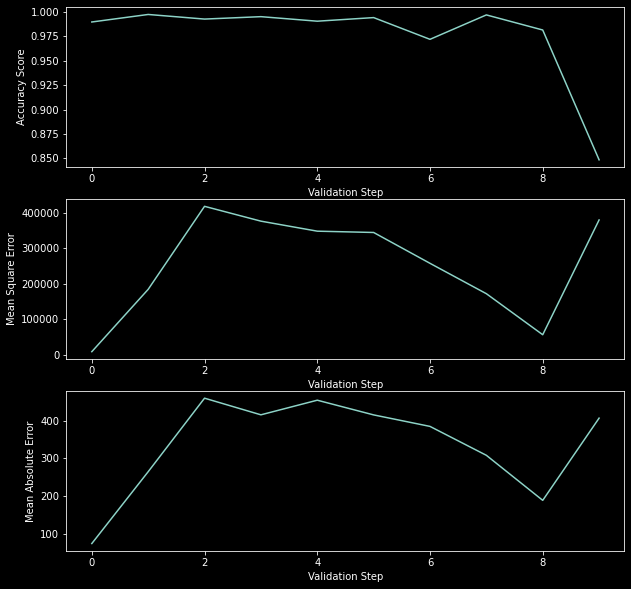

In [39]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=3)

ax[0].plot(scores)
ax[0].set_xlabel('Validation Step')
ax[0].set_ylabel('Accuracy Score')

ax[1].plot(mse)
ax[1].set_xlabel('Validation Step')
ax[1].set_ylabel('Mean Square Error')

ax[2].plot(mae)
ax[2].set_xlabel('Validation Step')
ax[2].set_ylabel('Mean Absolute Error')


plt.show()

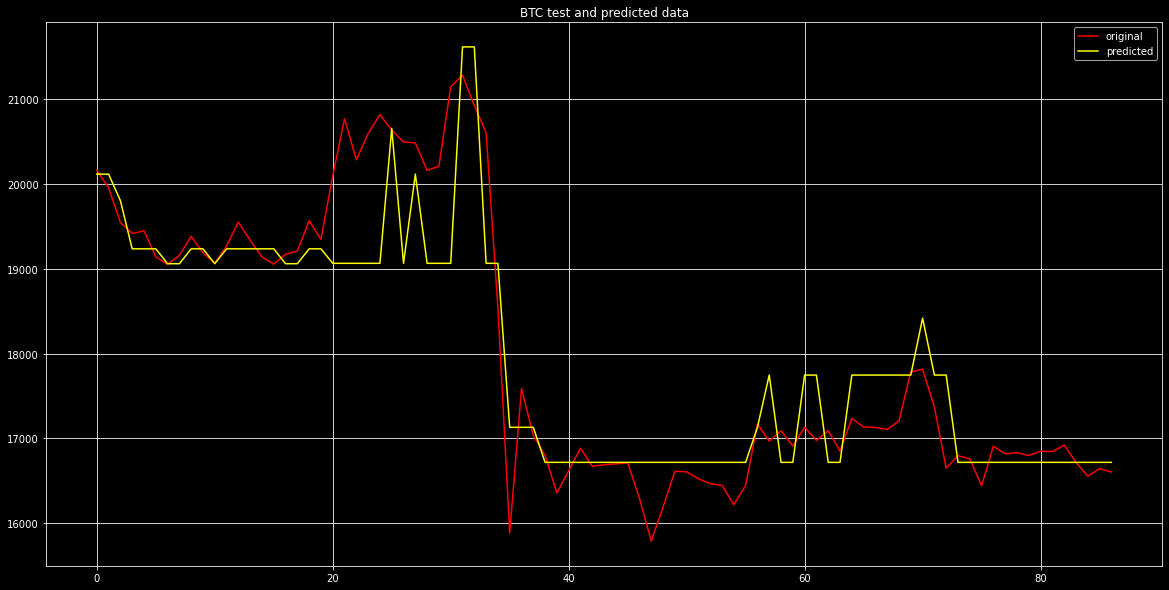

In [40]:
# Visualization 
y_pred = dt_model.predict(X_test)

x_ax = range(len(y_test))
plt.subplots(figsize=(20, 10))
plt.plot(x_ax, y_test, label="original", color = 'red')
plt.plot(x_ax, y_pred, label="predicted", color = 'yellow')
plt.title("BTC test and predicted data")
plt.grid()
plt.legend()
plt.show()

## Stacking Ensemble

In [41]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Initialize the models
rf_model = RandomForestRegressor(max_depth = 7, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 50)
xgb_model = XGBRegressor(learning_rate = 0.1, max_depth = 9, n_estimators = 50)
dt_model = DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 1, min_samples_split = 4, random_state = 42)

# Define the window size and step size for the walk-forward validation
window_size = 100
step_size = 10

# Initialize lists to store the predictions and actual values
meta_predictions = []
actual_values = []
mse_values = []
mae_values = []

# Iterate over the time-series data
for i in range(window_size, len(X_train), step_size):
    # Split the data into training and validation sets
    X_train_temp = X_train.iloc[i-window_size:i]
    y_train_temp = y_train.iloc[i-window_size:i]
    X_val = X_train.iloc[i:i+step_size]
    y_val = y_train.iloc[i:i+step_size]
    
    # Train the base models on the training data
    rf_model.fit(X_train_temp, y_train_temp)
    xgb_model.fit(X_train_temp, y_train_temp)
    dt_model.fit(X_train_temp, y_train_temp)

    # Use the base models to make predictions on the validation data
    rf_predictions = rf_model.predict(X_val)
    xgb_predictions = xgb_model.predict(X_val)
    dt_predictions = dt_model.predict(X_val)

    # Combine the predictions from the base models into a new dataset
    val_predictions = pd.DataFrame({
        "rf_predictions": rf_predictions,
        "xgb_predictions": xgb_predictions,
        "dt_predictions": dt_predictions
    })

    # Train a new meta model on the combined dataset of predictions
    meta_model = LinearRegression()
    meta_model.fit(val_predictions, y_val)

    # Use the meta model to make predictions on the validation set
    meta_predictions.append(meta_model.predict(val_predictions))
    actual_values.append(y_val)
    
    # Append MSE and MAE to the lists
    mse_values.append(mean_squared_error(y_val, meta_model.predict(val_predictions)))
    mae_values.append(mean_absolute_error(y_val, meta_model.predict(val_predictions)))


# Evaluate the performance of the meta model using mean squared error
mse = mean_squared_error(actual_values, meta_predictions)
mae = mean_absolute_error(actual_values, meta_predictions)
r2 = r2_score(actual_values, meta_predictions)
print("R2 Score: ", r2)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)

R2 Score:  0.9946301158784996
Mean Squared Error:  933005.9212800686
Mean Absolute Error:  625.7953279641695


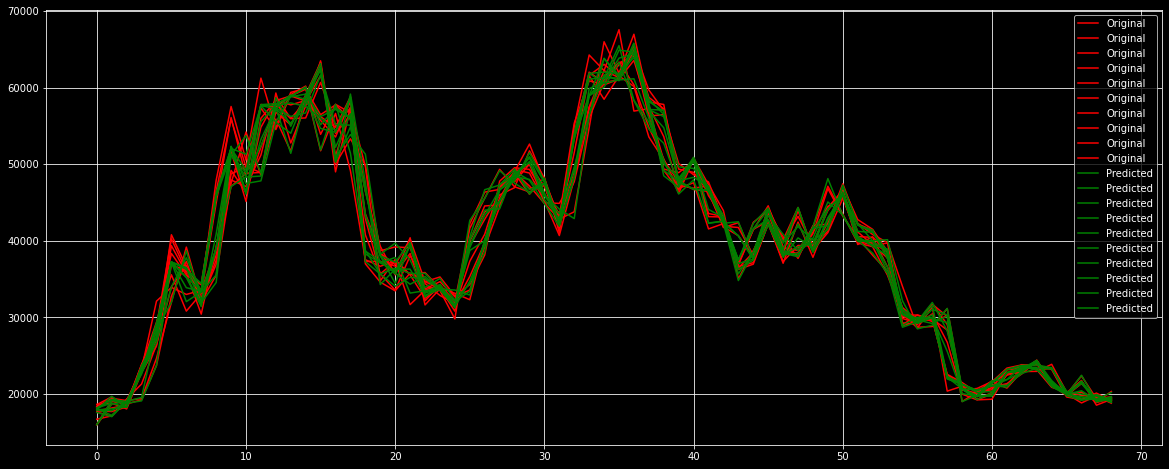

In [42]:
# Create a line plot of the original y and predicted y
fig = plt.subplots(figsize=(20, 8))

plt.plot(actual_values, label='Original', color = 'red')
plt.plot(meta_predictions, label='Predicted', color = 'green')

plt.legend()
plt.grid()
plt.show()

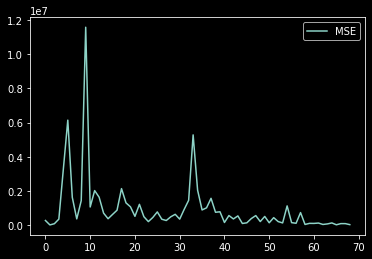

In [43]:
# Create a line plot of the MSE and MAE
plt.plot(mse_values, label='MSE')
plt.legend()
plt.show()

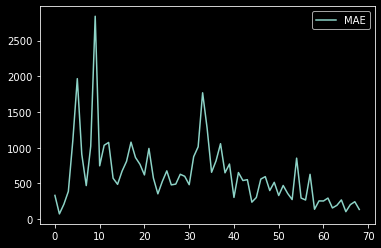

In [44]:
plt.plot(mae_values, label='MAE')
plt.legend()
plt.show()

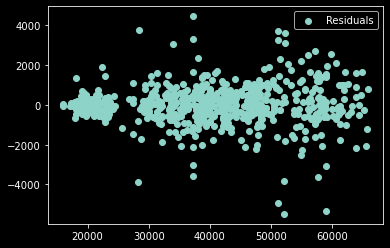

In [45]:
# Plot residuals
residuals = [p - a for p, a in zip(meta_predictions, actual_values)]
plt.scatter(meta_predictions, residuals, label='Residuals')
plt.legend()
plt.show()

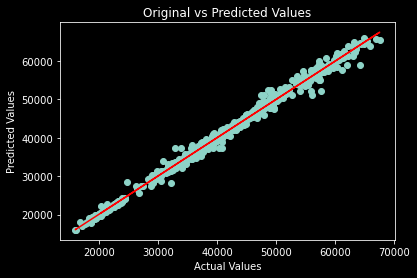

In [46]:
import matplotlib.pyplot as plt

# Flatten the lists of actual and predicted values
actual_values_flatten = [item for sublist in actual_values for item in sublist]
meta_predictions_flatten = [item for sublist in meta_predictions for item in sublist]

# Calculate the slope and intercept of the line of best fit
slope, intercept = np.polyfit(actual_values_flatten, meta_predictions_flatten, 1)

# Create a scatter plot of the original vs predicted values
plt.scatter(actual_values_flatten, meta_predictions_flatten)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

# Add the line of best fit to the scatter plot
plt.plot(actual_values_flatten, intercept + slope*np.array(actual_values_flatten), '-', color='r')
plt.title("Original vs Predicted Values")
plt.show()